<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/Modelling/Model%201/Demand_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import UnivariateSpline


In [7]:
files = ["Avg_Daily_Sales_Litres_ceypetco.csv","Avg_Daily_Sales_MT_ceypetco.csv","ciec_dataset_edited.csv","GDP_historical_data.csv","Import_Data_WITS.csv","Population_colombo.csv","Sales_IOC.csv","Transport_Report_Tables.csv" ]

In [8]:
ceypetco_sales_l_df = pd.read_csv(files[0]) # int64
ceypetco_sales_m_df = pd.read_csv(files[1]) # int64
ciec_df = pd.read_csv(files[2]) # float64
gdp_df = pd.read_csv(files[3]) # converted to float64
import_df = pd.read_csv(files[4]) # contains float64, int64 for years, object for the partner names and countries
population_df = pd.read_csv(files[5]) # converted float64
ioc_sales_df = pd.read_csv(files[6]) # converted to float64
transport_df = pd.read_csv(files[7]) # converted to float64


In [9]:
# Converting the ioc_sales data into float
ioc_sales_df = ioc_sales_df.replace({r'[\n,]': ''}, regex=True)
ioc_sales_df = ioc_sales_df.astype(float)

In [10]:
# Converting the gdp historical data into float
gdp_df = gdp_df.replace({r'[$%B,]':''},regex=True)
gdp_df = gdp_df.replace('',np.nan)
gdp_df = gdp_df.astype(float)

In [11]:
# converting the population df to float
population_df = population_df.replace({r'[,%]':''},regex=True)
population_df = population_df.replace('',np.nan)
population_df = population_df.astype(float)

In [12]:
# converting the transport df to float
transport_df_str = transport_df.iloc[:,0:2]
transport_df_n = transport_df.iloc[:, 2:].replace({r'[,%]':''},regex=True)
transport_df_n = transport_df_n.astype(float)
transport_df = transport_df_str.join(transport_df_n)

In [13]:
ciec_df['date'] = pd.to_datetime((ciec_df['date']))

In [69]:
ciec_df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports', 'tax_custom_import',
       'foreign_direct_investments', 'GDP_goods_services', 'GDP_gross_income',
       'government_debt', 'new_vehicle_registration', 'vehicle_sales',
       'port_stay_duration', 'vehicle_sales_asia_sl', 'num_vessels_colombo',
       'imports_refined_products', 'colombo_port_calls', 'tax_income_profit',
       'tax_export', 'tax_goods_services', 'tax_road_transport',
       'GDP_fce_households', 'diesel_user_price', 'petrol_user_price',
       'consumption_oil', 'sales_90_octane', 'sales_95_octane',
       'sales_auto_diesel', 'household_income', 'fuel_other_manufacture',
       'demand'],
      dtype='object')

## **Checking the data**

As the data has a lot of null values for certain periods of time it is necessary to fill them using certain interpolation techniques. The below are methods to check to see which method fits for each of the columns

In [57]:

def find_best_interpolation(df, date_col='date'):
    interpolation_methods = {}

    for col in df.columns:
        if col == date_col:
            continue

        df_clean = df[[date_col, col]].dropna()
        if df_clean.empty:
            interpolation_methods[col] = 'skip'
            continue

        df_clean[date_col] = df_clean[date_col].astype('int64')
        X = df_clean[date_col].values.reshape(-1, 1)
        y = df_clean[col].values

        # 1. Check for Linear Trend
        lin_model = LinearRegression()
        lin_model.fit(X, y)
        r2_score = lin_model.score(X, y)

        # 2. Check for Polynomial Trend (Degree 2)
        poly_model = Polynomial.fit(X.flatten(), y, 2)  # Degree 2 for polynomial
        y_poly_pred = poly_model(X.flatten())
        poly_error = np.mean((y - y_poly_pred) ** 2)

        # 3. Check for Spline Fit
        try:
            spline_model = UnivariateSpline(X.flatten(), y, s=1, k=3)  # Degree 3 cubic spline
            y_spline_pred = spline_model(X.flatten())
            spline_error = np.mean((y - y_spline_pred) ** 2)
        except Exception:
            spline_error = float('inf')  # If spline fails, assign high error

        # 4. Check for Step-like Changes (Nearest)
        diff_vals = np.abs(df_clean[col].diff()).median()
        if diff_vals > (df_clean[col].std() * 0.5):
            best_method = 'nearest'
        elif r2_score > 0.9:
            best_method = 'linear'
        elif poly_error < spline_error:
            best_method = 'polynomial'
        else:
            best_method = 'spline'

        interpolation_methods[col] = best_method

    return interpolation_methods


In [59]:
best_methods = find_best_interpolation(ciec_df, date_col='date')
print(best_methods)

{'fuel_consumption': 'spline', 'petroleum_imports': 'spline', 'tax_custom_import': 'spline', 'foreign_direct_investments': 'spline', 'GDP_goods_services': 'spline', 'GDP_gross_income': 'spline', 'government_debt': 'spline', 'new_vehicle_registration': 'spline', 'vehicle_sales': 'spline', 'port_stay_duration': 'spline', 'vehicle_sales_asia_sl': 'spline', 'num_vessels_colombo': 'spline', 'imports_refined_products': 'spline', 'colombo_port_calls': 'nearest', 'tax_income_profit': 'spline', 'tax_export': 'spline', 'tax_goods_services': 'spline', 'tax_road_transport': 'spline', 'GDP_fce_households': 'spline', 'diesel_user_price': 'spline', 'petrol_user_price': 'spline', 'consumption_oil': 'spline', 'sales_90_octane': 'linear', 'sales_95_octane': 'spline', 'sales_auto_diesel': 'spline', 'household_income': 'linear', 'fuel_other_manufacture': 'spline', 'demand': 'spline'}


In [52]:
lin_int = {'fuel_consumption': 'spline', 'petroleum_imports': 'spline', 'tax_custom_import': 'spline',
           'foreign_direct_investments': 'spline', 'GDP_goods_services': 'spline', 'GDP_gross_income': 'spline',
           'government_debt': 'spline', 'new_vehicle_registration': 'spline', 'vehicle_sales': 'spline',
           'port_stay_duration': 'spline', 'vehicle_sales_asia_sl': 'spline', 'num_vessels_colombo': 'spline',
           'imports_refined_products': 'spline', 'colombo_port_calls': 'nearest', 'tax_income_profit': 'spline', 'tax_export': 'spline',
           'tax_goods_services': 'spline', 'tax_road_transport': 'spline', 'GDP_fce_households': 'spline', 'diesel_user_price': 'spline',
           'petrol_user_price': 'spline', 'consumption_oil': 'spline', 'sales_90_octane': 'linear', 'sales_95_octane': 'spline',
           'sales_auto_diesel': 'spline', 'household_income': 'linear', 'fuel_other_manufacture': 'spline', 'demand': 'spline'}

In [60]:
for col, method in best_methods.items():
    if method != 'skip':
        if method == 'spline':
            ciec_df[col] = ciec_df[col].interpolate(method='spline', order=3)  # Cubic Spline
        elif method == 'polynomial':
            ciec_df[col] = ciec_df[col].interpolate(method='polynomial', order=2)  # Degree 2 Polynomial
        else:
            ciec_df[col] = ciec_df[col].interpolate(method=method)


In [66]:
missing_percentage = ciec_df.isna().sum() / len(ciec_df) * 100
print(missing_percentage)


date                           0.000000
fuel_consumption               0.000000
petroleum_imports             37.021277
tax_custom_import             35.141844
foreign_direct_investments    57.375887
GDP_goods_services            72.163121
GDP_gross_income              72.163121
government_debt               79.574468
new_vehicle_registration      22.198582
vehicle_sales                 62.907801
port_stay_duration            94.361702
vehicle_sales_asia_sl         62.907801
num_vessels_colombo           49.964539
imports_refined_products      37.021277
colombo_port_calls            94.503546
tax_income_profit             35.141844
tax_export                    35.141844
tax_goods_services            35.141844
tax_road_transport            64.751773
GDP_fce_households            72.163121
diesel_user_price             35.141844
petrol_user_price             35.141844
consumption_oil                0.000000
sales_90_octane               37.021277
sales_95_octane               51.808511


## **Preprocessing and data cleaning**

## **Models**

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [68]:
ciec_df['date'] = pd.to_datetime(ciec_df['date'])

In [78]:
rf_model = RandomForestRegressor()

In [81]:
# Select features and target variable
X = ciec_df.drop(columns=['demand'])
y = ciec_df['demand']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 2: Train ARIMA model (for time-series forecasting)
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Adjust order for ARIMA as needed
arima_model_fit = arima_model.fit()

# Step 3: Train SARIMA model (for seasonal time-series forecasting)
sarima_model = SARIMAX(y_train, order=(5, 1, 0), seasonal_order=(1, 1, 0, 12))  # Adjust parameters
sarima_model_fit = sarima_model.fit()

# # Step 4: Train Random Forest model (for machine learning approach)
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred_arima = arima_model_fit.forecast(len(y_test))
y_pred_sarima = sarima_model_fit.forecast(len(y_test))
# y_pred_rf = rf_model.predict(X_test)

# Step 6: Evaluate models using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae_arima = mean_absolute_error(y_test, y_pred_arima)
mse_arima = mean_squared_error(y_test, y_pred_arima)

mae_sarima = mean_absolute_error(y_test, y_pred_sarima)
mse_sarima = mean_squared_error(y_test, y_pred_sarima)

# mae_rf = mean_absolute_error(y_test, y_pred_rf)
# mse_rf = mean_squared_error(y_test, y_pred_rf)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
# Step 7: Print evaluation metrics
print(f'ARIMA - MAE: {mae_arima}, MSE: {mse_arima}')
print(f'SARIMA - MAE: {mae_sarima}, MSE: {mse_sarima}')
# print(f'Random Forest - MAE: {mae_rf}, MSE: {mse_rf}')


ARIMA - MAE: 1.3247835828844736, MSE: 2.1656186206378125
SARIMA - MAE: 9.024781912083869, MSE: 106.16656316306937


In [87]:
r2_score(y_test, y_pred_arima)

-4.274701091673681

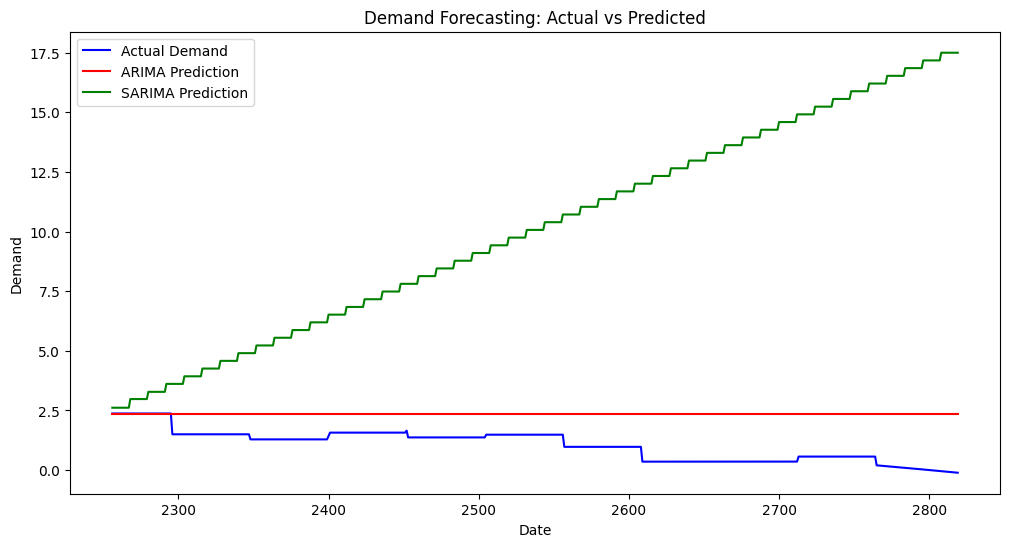

In [83]:
# Step 8: Plot the predictions for visual comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Demand', color='blue')
plt.plot(y_test.index, y_pred_arima, label='ARIMA Prediction', color='red')
plt.plot(y_test.index, y_pred_sarima, label='SARIMA Prediction', color='green')
# plt.plot(y_test.index, y_pred_rf, label='Random Forest Prediction', color='purple')
plt.legend()
plt.title('Demand Forecasting: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

In [85]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                 2256
Model:                 ARIMA(5, 1, 0)   Log Likelihood                5004.122
Date:                Fri, 31 Jan 2025   AIC                          -9996.243
Time:                        23:06:17   BIC                          -9961.918
Sample:                             0   HQIC                         -9983.716
                               - 2256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0790      0.011     -7.369      0.000      -0.100      -0.058
ar.L2         -0.0062      0.096     -0.065      0.948      -0.195       0.182
ar.L3         -0.0005      1.218     -0.000      1.0